# Time Series Analysis and Forecasting

## Load the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


## Visualize the data

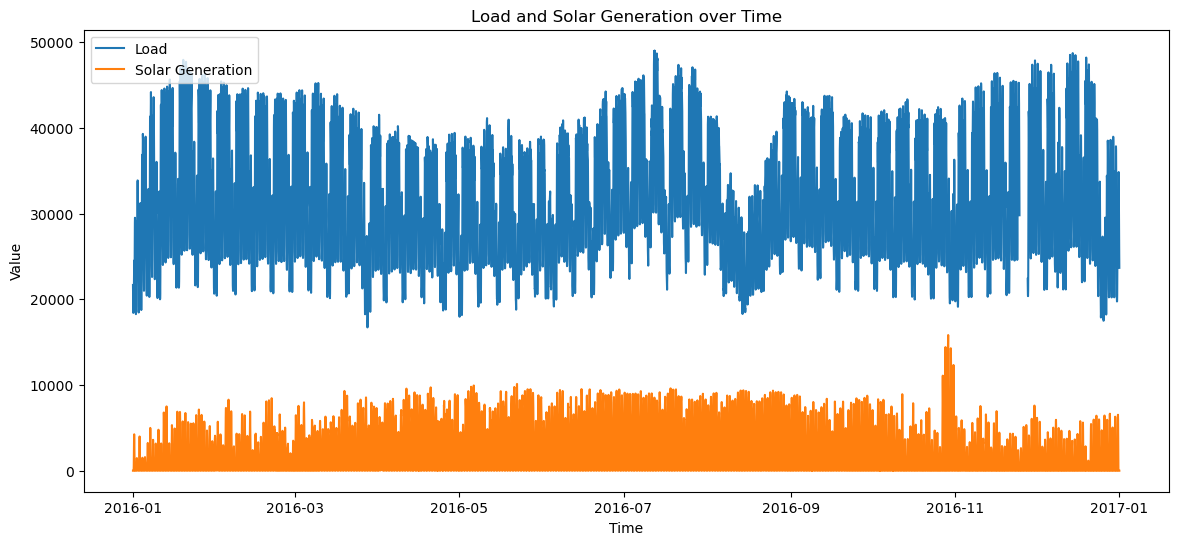

In [5]:
import matplotlib.pyplot as plt

# Convert utc_timestamp to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# Plot the data
plt.figure(figsize=(14,6))

plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

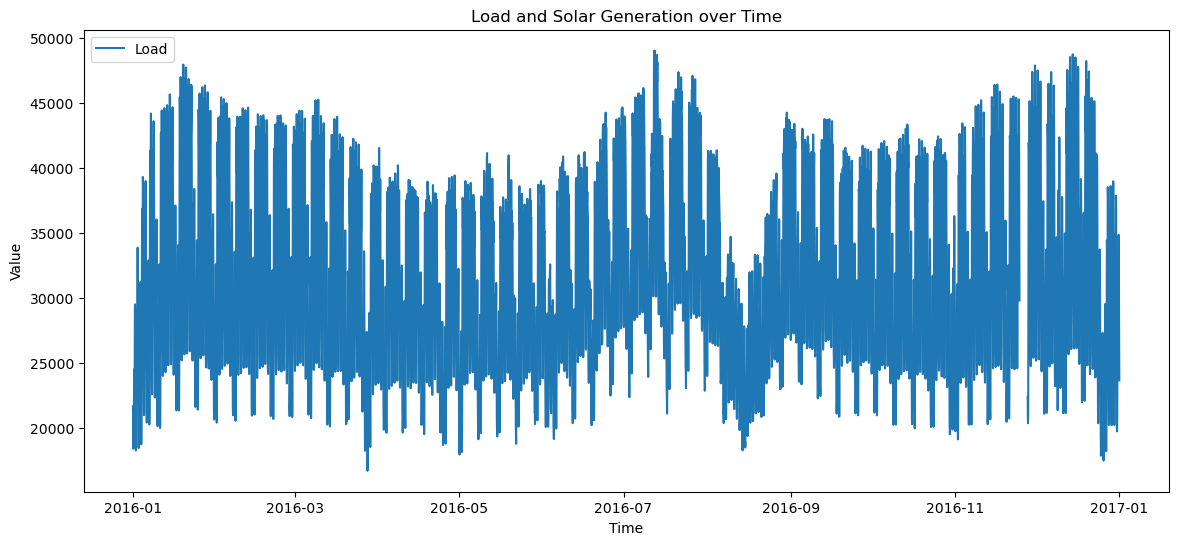

In [7]:
import matplotlib.pyplot as plt

# Convert utc_timestamp to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# Plot the data
plt.figure(figsize=(14,6))

plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
#plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

The plot shows both the load and solar generation over time for the year 2016. The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it's important to check for stationarity in your time series data. Stationarity is a property of time series data that implies the mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require the data to be stationary.

Let's perform an Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

## Handle missing values

In [3]:
# Check for missing values
data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [9]:
from statsmodels.tsa.stattools import adfuller

# Define function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
# Fill missing values using forward fill
data['IT_load_new'].fillna(method='ffill', inplace=True)

# Check for missing values again
print("Missing values after filling:")
print(data.isnull().sum())

Missing values after filling:
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_3680\3163531581.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['IT_load_new'].fillna(method='ffill', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3680\3163531581.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method='ffill', inplace=True)


## Check for stationarity

In [9]:
# Perform Augmented Dickey-Fuller test again
print("\nADF test for 'IT_load_new' after filling missing values:")
adf_test(data['IT_load_new'])

print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])


ADF test for 'IT_load_new' after filling missing values:
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


### from the Augmented Dickey-Fuller test:

For 'IT_load_new': The p-value is extremely small (much less than 0.05), so we reject the null hypothesis that the time series is non-stationary. Therefore, 'IT_load_new' can be considered stationary.

For 'IT_solar_generation': The p-value is also very small (much less than 0.05), so we reject the null hypothesis. This means 'IT_solar_generation' can be considered stationary as well.

Since both series are stationary, we can proceed with building an ARIMA model for each of them.

ARIMA, which stands for AutoRegressive Integrated Moving Average, is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors. The equation can be used to forecast future values.

An ARIMA model is characterized by 3 terms: p, d, q

p is the order of the AR term (number of lags of Y to be used as predictors).
q is the order of the MA term (moving average).
d is the number of differencing required to make the time series stationary.
In our case, since the series are already stationary, d=0 for both series. We need to determine the optimal values for p and q. To do this, we'll look at the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.



## Build ARIMA model for 'IT_load_new'

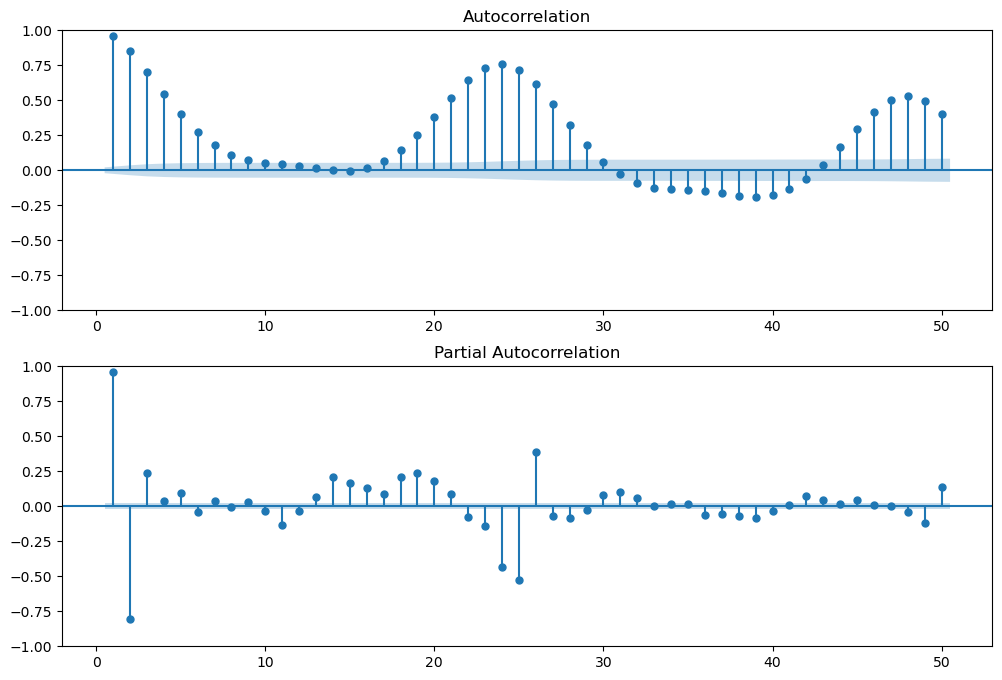

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

#### From the ACF plot, we see a fast decline, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=8 and q=3 as our model parameters.
We will use the first 80% of the data for training and the last 20% for testing. This way, we can evaluate the performance of our model on unseen data.

In [33]:
pip install pmdarima

  Using cached Cython-3.0.12-cp312-cp312-win_amd64.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:-

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
# Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

from pmdarima import auto_arima

stepwise_model = auto_arima(train, seasonal=False, trace=True)
print(stepwise_model.summary())
'''
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Fit the ARIMA model
model = ARIMA(train, order=(0, 0, 8))  # AR=0, I=0, MA=8
#model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

model = ARIMA(train_scaled, order=(0, 0, 8))
model_fit = model.fit()

# Predict on test set
predictions = model_fit.predict(start=len(train_scaled), end=len(train_scaled)+len(test_scaled)-1)
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))

model = ARIMA(train, order=(4, 1, 4))  
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse
'''

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=119377.693, Time=8.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=127179.476, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=121091.135, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122131.210, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=127177.487, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=120246.787, Time=1.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=119624.915, Time=6.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=119369.861, Time=7.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=119396.953, Time=9.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=119349.538, Time=12.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=119846.585, Time=3.32 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=119342.783, Time=14.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=119353.372, Time=7.22 sec
 ARIMA(5,

'\nscaler = MinMaxScaler()\ntrain_scaled = scaler.fit_transform(train.values.reshape(-1, 1))\ntest_scaled = scaler.transform(test.values.reshape(-1, 1))\n\n# Fit the ARIMA model\nmodel = ARIMA(train, order=(0, 0, 8))  # AR=0, I=0, MA=8\n#model = ARIMA(train, order=(2,0,2))\nmodel_fit = model.fit()\n\n# Make predictions on the test set\npredictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)\n\nmodel = ARIMA(train_scaled, order=(0, 0, 8))\nmodel_fit = model.fit()\n\n# Predict on test set\npredictions = model_fit.predict(start=len(train_scaled), end=len(train_scaled)+len(test_scaled)-1)\npredictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))\n\nmodel = ARIMA(train, order=(4, 1, 4))  # AR=0, I=0, MA=8\nmodel_fit = model.fit()\npredictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)\n# Calculate RMSE\nrmse = sqrt(mean_squared_error(test, predictions))\nrmse\n'

In [ ]:
On applying ARIMA with values 0,0,8 to make it behave as MA model and for other combinations the predictions are not good.Transformations like log also
didn't improve the results.
The p,d,q values suggested by Auto_arima model is also not giving good results. 
SARIMAX is giving better results than MA, ARIMA AND AUTO-ARIMA.

In [19]:
'''
model = ARIMA(train, order=(4, 0, 4)) 
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse
'''
train_log = np.log(train)
test_log = np.log(test)

model = ARIMA(train_log, order=(4, 0, 4))
model_fit = model.fit()

pred_log = model_fit.predict(start=len(train_log), end=len(train_log)+len(test_log)-1)
predictions = np.exp(pred_log)  # Reverse log

rmse = mean_squared_error(test, predictions, squared=False)
print(f"RMSE after log transformation: {rmse}")

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE after log transformation: 7813.886898898351


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


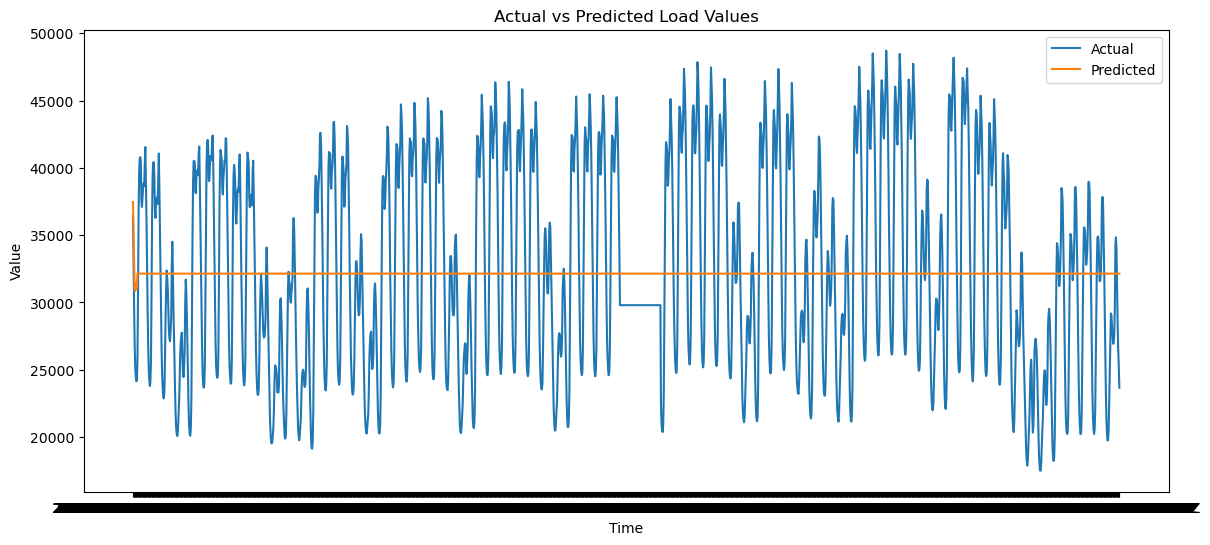

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

'''
The plot corresponding to ARIMA MODEL shows the actual versus predicted load values for the test set. While the ARIMA model seems to capture the general pattern and structure of 
the time series data, there are still some differences between the actual and predicted values.

This discrepancy could be due to various factors such as inherent randomness in the data, the presence of other unaccounted influences, or simply the 
limitations of the ARIMA model. More complex models or additional data preprocessing might improve the results. 
'''

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                          IT_load_new   No. Observations:                 7027
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -54780.230
Date:                              Sun, 20 Apr 2025   AIC                         109574.460
Time:                                      17:45:42   BIC                         109622.411
Sample:                                           0   HQIC                        109590.986
                                             - 7027                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4246      0.027     52.069      0.000       1.371       1.478
ar.L2         -0.45

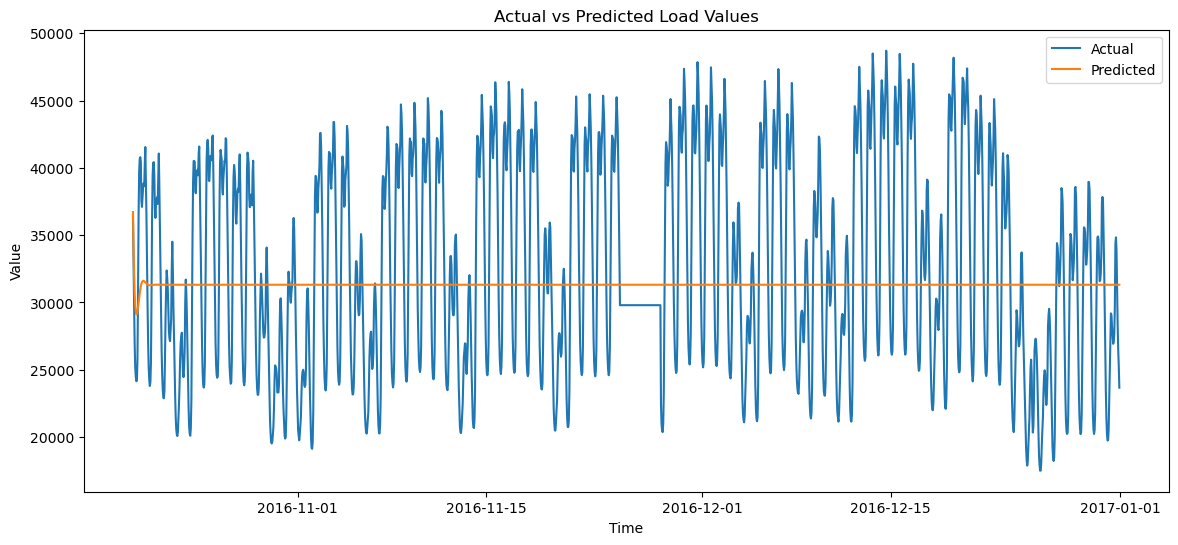

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, 
                order=(2, 0, 2),               # Non-seasonal (p,d,q)
                seasonal_order=(1, 1, 1, 24),  # Seasonal (P,D,Q,s) with daily (24 hours)
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)
print(model_fit.summary())

# Step 4: Forecast
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
#forecast = np.exp(forecast_log)  # Reverse log transform

# Step 5: Evaluate
#actual = data['IT_load_new'].iloc[train_size:]
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')

# Step 6: Plot
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test, forecast)
print(f"MAPE: {mape*100:.2f}%")

MAPE: 14.43%


In [35]:
pip install prophet



   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   - --------------

In [21]:
from prophet import Prophet

df= pd.read_csv('TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp']).dt.tz_localize(None)
df = df.rename(columns={'utc_timestamp': 'ds', 'IT_load_new': 'y'})
df['y'].fillna(method='ffill', inplace=True)

df = df.sort_values('ds')
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=len(test), freq='H')  # hourly frequency

# Forecast
forecast = model.predict(future)
predictions = forecast[['ds', 'yhat']].iloc[-len(test):]

# Now calculate RMSE using the same style
rmse = sqrt(mean_squared_error(test['y'].values, predictions['yhat'].values))
print(f"Prophet RMSE: {rmse:.2f}")
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test['y'].values, predictions['yhat'].values)
print(f"MAPE: {mape*100:.2f}%")

C:\Users\hp\AppData\Local\Temp\ipykernel_3680\3035750352.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['y'].fillna(method='ffill', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3680\3035750352.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y'].fillna(method='ffill', inplace=True)
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\

Prophet RMSE: 4365.83
MAPE: 11.46%


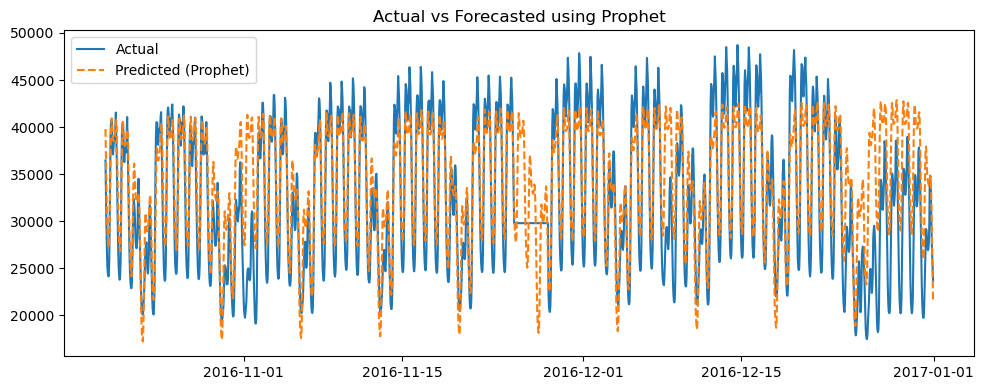

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted (Prophet)', linestyle='--')
plt.title("Actual vs Forecasted using Prophet")
plt.legend()
plt.tight_layout()
plt.show()

The root mean squared error (RMSE) for the ARIMA model on 'IT_load_new' is approximately 7715. RMSE is a measure of the differences between the values predicted by a model and the values actually observed. It's a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

However, the value of RMSE itself is not as informative as comparing it to some benchmark, like the standard deviation of the response, or comparing between different models for the same dataset. The MAPE is calculated and giving better results for SARIMAX and PROPHET models.


Let's repeat the process for the 'IT_solar_generation' time series. We'll start by plotting the ACF and PACF to determine the parameters for the ARIMA model.

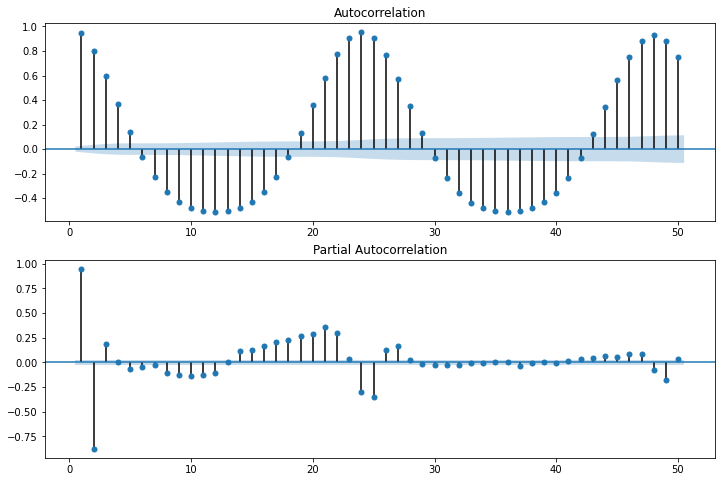

In [16]:
# Plot ACF and PACF for 'IT_solar_generation'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.150711088173

The root mean squared error (RMSE) for the ARIMA model on 'IT_solar_generation' is approximately 2486. As with the 'IT_load_new' model, this RMSE value can be used as a measure of how accurately the model predicts the response.

Again, it's beneficial to plot the actual values and the forecasted values to visualize how well our model is performing.

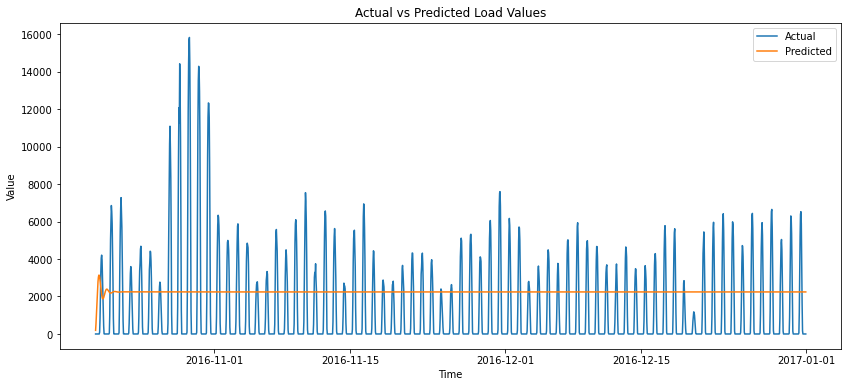

In [18]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

The plot shows the actual versus predicted solar generation values for the test set. As with the load model, the ARIMA model seems to capture the general pattern of the time series data. 